In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import numpy as np
import torch
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

from scipy.stats import trim_mean

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    # c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    # return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

palette1 = ['#227c9d', '#17c3b2', '#a9def9', '#ffcb77', '#fe6d73']
palette2 = ['#227c9d', '#17c3b2', '#a9def9', '#ffcb77', '#fe6d73']
# scala
palette3 = ['#B3BEFF', '#959ED4', '#7D85B3', '#656C91', '#4D526F']

palette3 = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']
palette3_light = [adjust_lightness(c, 0.7) for c in palette3]
palette3_dark = [adjust_lightness(c, 1.3) for c in palette3]

icl_color = '#9BB0C1'

cromos = ['#FAEDCB', '#F7D9C4', '#C9E4DE', '#C6DEF1', '#DBCDF0', '#F2C6DE', '#F9C6C9']
cromos = [adjust_lightness(c, 1.4) for c in cromos]

def read_results(result_path):
    with open(result_path) as f:
        results = json.load(f)
    return results

# get statistics
def clean_results(results):
    to_return = {k: [] for k in results[0]['out'].keys()}
    for ele in results:
        for type, value in ele['eval'].items():
            to_return[type].append(value['output'])
    
    return to_return

In [53]:
# load results
task1 = 'ENi2f'
task2 = 'FRA'
task_comp = 'FRi2f'
opposite_task = 'ENf2i'
language_to_count = 'fr'
label_to_count = '0'

# task1 = 'ENunsafe'
# task2 = 'SPA'
# task_comp = 'SPunsafe'
# opposite_task = 'ENsafe'
# language_to_count = 'es'
# label_to_count = 'unsafe'

res = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/{task1}/{task1}-{task2}/all_evaluated_{task1}_{task2}_tok30.json')
res_manual_comp = read_results(f'./../output/Mistral-7B-Instruct-v0.2/{task_comp}/diff/all_evaluated_icl4_tok30_{task_comp}-{opposite_task}.json')

avg_perplexity = {}
avg_perplexity_filtered = {}
perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
ci_labels = {}

for k in res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))


    # correct perlexities (only when the icl is in the same language as the one to count AND the label is the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in res 
        if (ele['eval_lang'][f'icl_{task_comp}']['lang'] == language_to_count and str(ele['eval_task'][k]['output']) == label_to_count)
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in res[0]['output']:
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [str(ele['eval_task'][k]['output']) for ele in res]
    avg_labels[k] = all_labels.count(str(label_to_count)) / len(all_labels)
    all_scores = [ele['eval_task'][k][label_to_count] for ele in res]
    ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

# Baselines
man_lbl_scores_noicl = [ele['eval_task']['no_icl'][label_to_count] for ele in res_manual_comp]
man_lbl_avg_noicl = np.mean(man_lbl_scores_noicl)
man_lbl_ci_noicl = 1.96 * np.std(man_lbl_scores_noicl)/np.sqrt(len(man_lbl_scores_noicl))
man_lbl_scores_icl = [ele['eval_task']['icl'][label_to_count] for ele in res_manual_comp]
man_lbl_avg_icl = np.mean(man_lbl_scores_icl)
man_lbl_ci_icl = 1.96 * np.std(man_lbl_scores_icl)/np.sqrt(len(man_lbl_scores_icl))

man_lan_scores_noicl = [ele['eval_lang']['no_icl'][language_to_count] for ele in res_manual_comp]
man_lan_avg_noicl = np.mean(man_lan_scores_noicl)
man_lan_ci_noicl = 1.96 * np.std(man_lan_scores_noicl)/np.sqrt(len(man_lan_scores_noicl))
man_lan_scores_icl = [ele['eval_lang']['icl'][language_to_count] for ele in res_manual_comp]
man_lan_avg_icl = np.mean(man_lan_scores_icl)
man_lan_ci_icl = 1.96 * np.std(man_lan_scores_icl)/np.sqrt(len(man_lan_scores_icl))

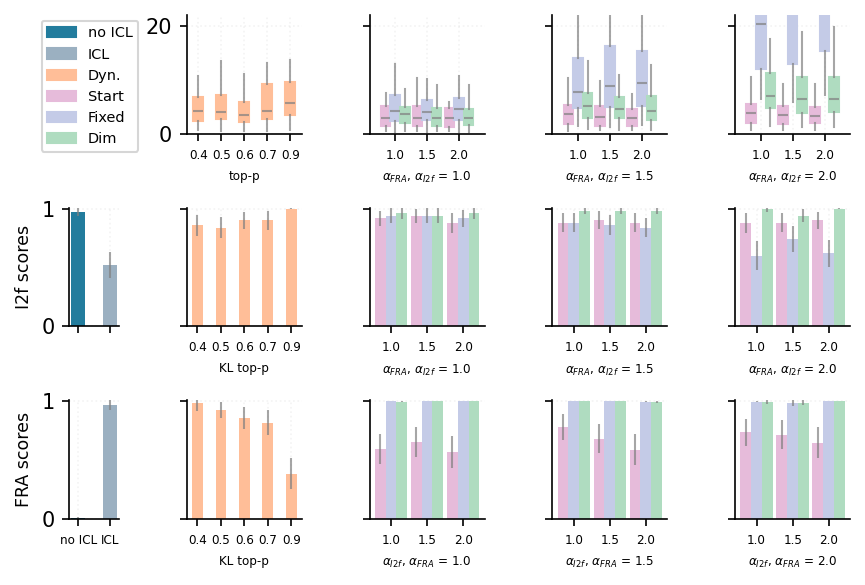

In [54]:
fig = plt.figure(figsize=(6, 4), dpi = 150)
spec = fig.add_gridspec(ncols=5, nrows=3, width_ratios=[1.3, 3, 3, 3, 3])
ax0 = fig.add_subplot(spec[5])
ax0_d = fig.add_subplot(spec[6])
ax1 = fig.add_subplot(spec[7])
ax2 = fig.add_subplot(spec[8])
ax3 = fig.add_subplot(spec[9])
ax4 = fig.add_subplot(spec[10])
ax4_d = fig.add_subplot(spec[11])
ax5 = fig.add_subplot(spec[12])
ax6 = fig.add_subplot(spec[13])
ax7 = fig.add_subplot(spec[14])

alpha_used = [1.0, 1.5, 2.0]

width = 0.3
distance = 0.05
error_kw = {"error_kw": dict(ecolor='gray', alpha=.7, lw=1)}

dynamic_color = '#FFBE98'
start_color = '#E6BBDA'
fixed_color = '#C4CBE7'
dim_color = '#AFDCC0'

# dynamic
# ex palette3[3]
ax0_d.bar(0, avg_labels[f'dynamic_p0.4_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.4_{task1}-{task2}'], **error_kw)
ax0_d.bar(1, avg_labels[f'dynamic_p0.5_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.5_{task1}-{task2}'], **error_kw)
ax0_d.bar(2, avg_labels[f'dynamic_p0.6_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.6_{task1}-{task2}'], **error_kw)
ax0_d.bar(3, avg_labels[f'dynamic_p0.7_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.7_{task1}-{task2}'], **error_kw)
ax0_d.bar(4, avg_labels[f'dynamic_p0.9_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.9_{task1}-{task2}'], **error_kw)
ax0_d.set_ylim([0, 1.01])
ax0_d.grid(alpha=.15, ls=':')
ax0_d.set_axisbelow(True)
ax0_d.spines['top'].set_visible(False)
ax0_d.spines['right'].set_visible(False)
ax0_d.tick_params(labelleft=False)
ax0_d.set_xticks([0, 1, 2, 3, 4], ['0.4', '0.5', '0.6', '0.7',  '0.9'], fontsize='xx-small')
ax0_d.set_xlabel('KL top-p', fontsize='xx-small')
# ax0_d.set_xlim((-1,1))

ax4_d.bar(0, avg_language[f'dynamic_p0.4_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_language[f'dynamic_p0.5_{task1}-{task2}'], **error_kw)
ax4_d.bar(1, avg_language[f'dynamic_p0.5_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_language[f'dynamic_p0.5_{task1}-{task2}'], **error_kw)
ax4_d.bar(2, avg_language[f'dynamic_p0.6_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_language[f'dynamic_p0.6_{task1}-{task2}'], **error_kw)
ax4_d.bar(3, avg_language[f'dynamic_p0.7_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_language[f'dynamic_p0.7_{task1}-{task2}'], **error_kw)
ax4_d.bar(4, avg_language[f'dynamic_p0.9_{task1}-{task2}'], width * 1.5, color=dynamic_color, yerr=ci_language[f'dynamic_p0.9_{task1}-{task2}'], **error_kw)
ax4_d.set_ylim([0, 1.01])
ax4_d.grid(alpha=.15, ls=':')
ax4_d.set_axisbelow(True)
ax4_d.spines['top'].set_visible(False)
ax4_d.spines['right'].set_visible(False)
ax4_d.tick_params(labelleft=False)
ax4_d.set_xticks([0, 1, 2, 3, 4], ['0.4', '0.5', '0.6', '0.7',  '0.9'], fontsize='xx-small')
ax4_d.set_xlabel('KL top-p', fontsize='xx-small')
# ax0_d.set_xlim((-1,1))
# ax4_d.set_xlim((-1,1))

# noicl ITunsafe, icl ITunsafe, + ITA steer(0 unsafe)
ax0.bar(0, man_lbl_avg_noicl, width*1.5, color=palette1[0], yerr=man_lbl_ci_noicl, **error_kw)
ax0.bar(1, man_lbl_avg_icl, width*1.5, color=icl_color, yerr=man_lbl_ci_icl, **error_kw)
ax0.set_ylabel(task1.replace('EN', '').capitalize() + ' accuracy', fontsize='small')
ax0.set_ylim([0, 1.01])
ax0.grid(alpha=.15, ls=':')
ax0.set_axisbelow(True)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(labelbottom=False)

ax4.bar(0, man_lan_avg_noicl, width*1.5, color=palette1[0], yerr=man_lan_ci_noicl, **error_kw)
ax4.bar(1, man_lan_avg_icl, width*1.5, color=icl_color, yerr=man_lan_ci_icl, **error_kw)
ax4.set_xticks([0, 1], ['no ICL', 'ICL'], fontsize='xx-small')
ax4.set_ylabel(task2 + ' accuracy', fontsize='small')
ax4.set_ylim([0, 1.01])
ax4.grid(alpha=.15, ls=':')
ax4.set_axisbelow(True)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

task1_axs = [ax1, ax2, ax3]
for i, a in enumerate(alpha_used):
    for j, b in enumerate(alpha_used):
        task1_axs[i].bar(j - width, avg_labels[f'START{a}_{task1}-{b}_{task2}'], width, color=start_color, yerr=ci_labels[f'START{a}_{task1}-{b}_{task2}'], **error_kw)
        task1_axs[i].bar(j - 0* width, avg_labels[f'{a}_{task1}-{b}_{task2}'], width, color=fixed_color, yerr=ci_labels[f'{a}_{task1}-{b}_{task2}'], **error_kw)
        task1_axs[i].bar(j + width, avg_labels[f'DIM{a}_{task1}-{b}_{task2}'], width, color=dim_color, yerr=ci_labels[f'DIM{a}_{task1}-{b}_{task2}'], **error_kw)
    # task1_axs[i].set_title(r'$\alpha_{task}$ = ' + f'{a}', fontsize='small')
    task1_axs[i].set_ylim([0, 1.01])
    task1_axs[i].set_xticks(np.arange(len(alpha_used)), [str(alpha) for alpha in alpha_used], fontsize='xx-small')
    task1_axs[i].grid(alpha=.15, ls=':')
    task1_axs[i].set_axisbelow(True)
    task1_axs[i].spines['top'].set_visible(False)
    task1_axs[i].spines['right'].set_visible(False)
    task1_axs[i].tick_params(labelleft=False)
    task1_axs[i].set_xlabel(fr'$\alpha_{{{task2}}}$, $\alpha_{{{task1.replace("EN", "").capitalize()}}}$ = {a}', fontsize='xx-small')
    # task1_axs[i].tick_params(labelbottom=False)

task2_axs = [ax5, ax6, ax7]
for i, a in enumerate(alpha_used):
    for j, b in enumerate(alpha_used):
        task2_axs[i].bar(j -width, avg_language[f'START{b}_{task1}-{a}_{task2}'], width, color=start_color, yerr=ci_language[f'START{b}_{task1}-{a}_{task2}'], **error_kw)
        task2_axs[i].bar(j - 0* width/2, avg_language[f'{b}_{task1}-{a}_{task2}'], width, color=fixed_color, yerr=ci_language[f'{b}_{task1}-{a}_{task2}'], **error_kw)
        task2_axs[i].bar(j +width, avg_language[f'DIM{b}_{task1}-{a}_{task2}'], width, color=dim_color, yerr=ci_language[f'DIM{b}_{task1}-{a}_{task2}'], **error_kw)
    # task2_axs[i].set_title(r'$\alpha_{ita}$ = ' + f'{a}')
    task2_axs[i].set_ylim([0, 1.01])
    task2_axs[i].set_xticks(np.arange(len(alpha_used)), [str(alpha) for alpha in alpha_used], fontsize='xx-small')
    task2_axs[i].grid(alpha=.15, ls=':')
    task2_axs[i].set_axisbelow(True)
    task2_axs[i].spines['top'].set_visible(False)
    task2_axs[i].spines['right'].set_visible(False)
    task2_axs[i].tick_params(labelleft=False)
    task2_axs[i].set_xlabel(fr'$\alpha_{{{task1.replace("EN", "").capitalize()}}}$, $\alpha_{{{task2}}}$ = {a}', fontsize='xx-small')


def set_basic(ax):
    ax.set_ylim([0, 21.99])
    ax.grid(alpha=.15, ls=':')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelleft=False)
    return ax

# ax8 = fig.add_subplot(spec[10])
# ax8.set_ylim([0, 4.01])
# ax8.grid(alpha=.15, ls=':')
# ax8.set_axisbelow(True)
# ax8.set_ylabel(r'$\Delta$ perplexity from ICL', fontsize='small')

ax_l = fig.add_subplot(spec[0])
legend_patches = [
    mpatches.Patch(color=palette1[0], label=r'no ICL'),
    mpatches.Patch(color=icl_color, label=r'ICL'),
    mpatches.Patch(color=dynamic_color, label=r'Dyn'),
    mpatches.Patch(color=start_color, label=r'Start'),
    mpatches.Patch(color=fixed_color, label=r'Fixed'),
    mpatches.Patch(color=dim_color, label=r'Dim'),
]
ax_l.legend(
    handles=legend_patches,# labels=amount_of_edit, 
    loc='center left',
    ncol=1, fontsize='x-small', handler_map = {list: HandlerTuple(None)},
    bbox_to_anchor=(-0.7, 0.4)  # (0.5, 0.5) is center right (h, v)
)
# remove axes from ax_l
ax_l.axis('off')

ax9 = set_basic(fig.add_subplot(spec[1]))
ax9.tick_params(labelleft=True)
ax10 = set_basic(fig.add_subplot(spec[2]))
ax11 = set_basic(fig.add_subplot(spec[3]))
ax12 = set_basic(fig.add_subplot(spec[4]))


dynamic_perplexity = [
    perplexity_filtered[f'dynamic_p0.4_{task1}-{task2}'], 
    perplexity_filtered[f'dynamic_p0.5_{task1}-{task2}'], 
    perplexity_filtered[f'dynamic_p0.6_{task1}-{task2}'], 
    perplexity_filtered[f'dynamic_p0.7_{task1}-{task2}'], 
    perplexity_filtered[f'dynamic_p0.9_{task1}-{task2}']
]
bplot = ax9.boxplot(dynamic_perplexity, widths=width * 1.5, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor('#FFBE98')
    patch.set_edgecolor('#FFBE98')
    median.set_color('gray')
    median.set_alpha(0.7)

ax9.set_xticks([1, 2, 3, 4, 5], ['0.4', '0.5', '0.6', '0.7',  '0.9'], fontsize='xx-small')
ax9.set_xlabel('top-p', fontsize='xx-small')

start_1_task1_ppls = [
    perplexity_filtered[f'START1.0_{task1}-1.0_{task2}'],
    perplexity_filtered[f'START1.0_{task1}-1.5_{task2}'],
    perplexity_filtered[f'START1.0_{task1}-2.0_{task2}']
]
fixed_1_task1_ppls = [
    perplexity_filtered[f'1.0_{task1}-1.0_{task2}'], 
    perplexity_filtered[f'1.0_{task1}-1.5_{task2}'], 
    perplexity_filtered[f'1.0_{task1}-2.0_{task2}']
]
dim_1_task1_ppls = [
    perplexity_filtered[f'DIM1.0_{task1}-1.0_{task2}'], 
    perplexity_filtered[f'DIM1.0_{task1}-1.5_{task2}'], 
    perplexity_filtered[f'DIM1.0_{task1}-2.0_{task2}']
]
bplot = ax10.boxplot(
    start_1_task1_ppls, positions=np.arange(3) - width,
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(start_color)
    patch.set_edgecolor(start_color)
    median.set_color('gray')
    median.set_alpha(0.7)
bplot = ax10.boxplot(
    fixed_1_task1_ppls, positions=np.arange(3),
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(fixed_color)
    patch.set_edgecolor(fixed_color)
    median.set_color('gray')
    median.set_alpha(0.7)
bplot = ax10.boxplot(
    dim_1_task1_ppls, positions=np.arange(3) + width,
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(dim_color)
    patch.set_edgecolor(dim_color)
    median.set_color('gray')
    median.set_alpha(0.7)
ax10.set_xticks(np.arange(3), [str(alpha) for alpha in alpha_used], fontsize='xx-small')
ax10.set_xlabel(fr'$\alpha_{{{task2}}}$, $\alpha_{{{task1.replace("EN", "").capitalize()}}}$ = 1.0', fontsize='xx-small')

start_15_task1_ppls = [
    perplexity_filtered[f'START1.5_{task1}-1.0_{task2}'],
    perplexity_filtered[f'START1.5_{task1}-1.5_{task2}'],
    perplexity_filtered[f'START1.5_{task1}-2.0_{task2}']
]
fixed_15_task1_ppls = [
    perplexity_filtered[f'1.5_{task1}-1.0_{task2}'], 
    perplexity_filtered[f'1.5_{task1}-1.5_{task2}'], 
    perplexity_filtered[f'1.5_{task1}-2.0_{task2}']
]
dim_15_task1_ppls = [
    perplexity_filtered[f'DIM1.5_{task1}-1.0_{task2}'], 
    perplexity_filtered[f'DIM1.5_{task1}-1.5_{task2}'], 
    perplexity_filtered[f'DIM1.5_{task1}-2.0_{task2}']
]
bplot = ax11.boxplot(
    start_15_task1_ppls, positions=np.arange(3) - width,
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(start_color)
    patch.set_edgecolor(start_color)
    median.set_color('gray')
    median.set_alpha(0.7)
bplot = ax11.boxplot(
    fixed_15_task1_ppls, positions=np.arange(3),
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(fixed_color)
    patch.set_edgecolor(fixed_color)
    median.set_color('gray')
    median.set_alpha(0.7)
bplot = ax11.boxplot(
    dim_15_task1_ppls, positions=np.arange(3) + width,
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(dim_color)
    patch.set_edgecolor(dim_color)
    median.set_color('gray')
    median.set_alpha(0.7)
ax11.set_xticks(np.arange(3), [str(alpha) for alpha in alpha_used], fontsize='xx-small')
ax11.set_xlabel(fr'$\alpha_{{{task2}}}$, $\alpha_{{{task1.replace("EN", "").capitalize()}}}$ = 1.5', fontsize='xx-small')

start_2_task1_ppls = [
    perplexity_filtered[f'START2.0_{task1}-1.0_{task2}'],
    perplexity_filtered[f'START2.0_{task1}-1.5_{task2}'],
    perplexity_filtered[f'START2.0_{task1}-2.0_{task2}']
]
fixed_2_task1_ppls = [
    perplexity_filtered[f'2.0_{task1}-1.0_{task2}'], 
    perplexity_filtered[f'2.0_{task1}-1.5_{task2}'], 
    perplexity_filtered[f'2.0_{task1}-2.0_{task2}']
]
dim_2_task1_ppls = [
    perplexity_filtered[f'DIM2.0_{task1}-1.0_{task2}'], 
    perplexity_filtered[f'DIM2.0_{task1}-1.5_{task2}'], 
    perplexity_filtered[f'DIM2.0_{task1}-2.0_{task2}']
]
bplot = ax12.boxplot(
    start_2_task1_ppls, positions=np.arange(3) - width,
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(start_color)
    patch.set_edgecolor(start_color)
    median.set_color('gray')
    median.set_alpha(0.7)
bplot = ax12.boxplot(
    fixed_2_task1_ppls, positions=np.arange(3),
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(fixed_color)
    patch.set_edgecolor(fixed_color)
    median.set_color('gray')
    median.set_alpha(0.7)
bplot = ax12.boxplot(
    dim_2_task1_ppls, positions=np.arange(3) + width,
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
for patch, median in zip(bplot['boxes'], bplot['medians']):
    patch.set_facecolor(dim_color)
    patch.set_edgecolor(dim_color)
    median.set_color('gray')
    median.set_alpha(0.7)

ax12.set_xticks(np.arange(3), [str(alpha) for alpha in alpha_used], fontsize='xx-small')
ax12.set_xlabel(fr'$\alpha_{{{task2}}}$, $\alpha_{{{task1.replace("EN", "").capitalize()}}}$ = 2.0', fontsize='xx-small')

fig.tight_layout()
fig.savefig(f'./media/compositionality/{task1}_{task2}.pdf', bbox_inches='tight')

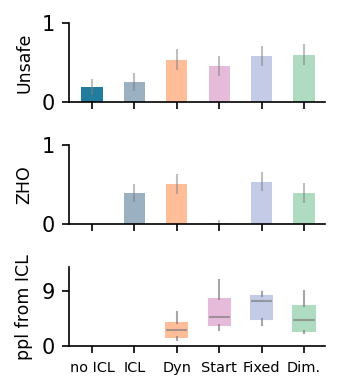

In [357]:
fig, axes = plt.subplots(
    figsize=(2.5, 2.7), dpi=150,
    nrows=3, ncols=1, sharex=True,
    gridspec_kw={'height_ratios': [1, 1, 1]},
)

dynamic_color = '#FFBE98'
start_color = '#83CBD6'
fixed_color = '#b8b3e9'
dim_color = '#d999b9'

dynamic_color = '#FFBE98'
start_color = '#E6BBDA'
fixed_color = '#C4CBE7'
dim_color = '#AFDCC0'


ax0, ax1, ax2 = axes
x_ticks = [0, 1, 2, 3, 4, 5]
labels = ['no ICL', 'ICL', 'Dyn', 'Start', 'Fixed', 'Dim.']

width = 0.5
distance = 0.05
error_kw = {"error_kw": dict(ecolor='gray', alpha=.5, lw=1)}
p = '0.5'
a, b = '1.5', '1.0'     # alpha for task1, alpha for task2

ax0.bar(0, man_lbl_avg_noicl, width, color=palette1[0], yerr=man_lbl_ci_noicl, **error_kw)
ax0.bar(1, man_lbl_avg_icl, width, color=icl_color, yerr=man_lbl_ci_icl, **error_kw)
ax0.bar(2, avg_labels[f'dynamic_p{p}_{task1}-{task2}'], width, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.5_{task1}-{task2}'], **error_kw)
ax0.bar(3, avg_labels[f'START{a}_{task1}-{b}_{task2}'], width, color=start_color, yerr=ci_labels[f'START{a}_{task1}-{b}_{task2}'], **error_kw)
ax0.bar(4, avg_labels[f'{a}_{task1}-{b}_{task2}'], width, color=fixed_color, yerr=ci_labels[f'{a}_{task1}-{b}_{task2}'], **error_kw)
ax0.bar(5, avg_labels[f'DIM{a}_{task1}-{b}_{task2}'], width, color=dim_color, yerr=ci_labels[f'DIM{a}_{task1}-{b}_{task2}'], **error_kw)

ax1.bar(0, man_lan_avg_noicl, width, color=palette1[0], yerr=man_lan_ci_noicl, **error_kw)
ax1.bar(1, man_lan_avg_icl, width, color=icl_color, yerr=man_lan_ci_icl, **error_kw)
ax1.bar(2, avg_language[f'dynamic_p{p}_{task1}-{task2}'], width, color=dynamic_color, yerr=ci_language[f'dynamic_p0.5_{task1}-{task2}'], **error_kw)
ax1.bar(3, avg_language[f'START{a}_{task1}-{b}_{task2}'], width, color=start_color, yerr=ci_language[f'START{a}_{task1}-{b}_{task2}'], **error_kw)
ax1.bar(4, avg_language[f'{a}_{task1}-{b}_{task2}'], width, color=fixed_color, yerr=ci_language[f'{a}_{task1}-{b}_{task2}'], **error_kw)
ax1.bar(5, avg_language[f'DIM{a}_{task1}-{b}_{task2}'], width, color=dim_color, yerr=ci_language[f'DIM{a}_{task1}-{b}_{task2}'], **error_kw)

bplot = ax2.boxplot(
    perplexity_filtered[f'dynamic_p{p}_{task1}-{task2}'], 
    positions=[2],
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
bplot['boxes'][0].set_facecolor(dynamic_color)
bplot['boxes'][0].set_edgecolor(dynamic_color)
bplot['medians'][0].set_color('gray')
bplot['medians'][0].set_alpha(0.7)

bplot = ax2.boxplot(
    perplexity_filtered[f'{a}_{task1}-{b}_{task2}'], 
    positions=[3],
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
bplot['boxes'][0].set_facecolor(start_color)
bplot['boxes'][0].set_edgecolor(start_color)
bplot['medians'][0].set_color('gray')
bplot['medians'][0].set_alpha(0.7)

bplot = ax2.boxplot(
    perplexity_filtered[f'START{a}_{task1}-{b}_{task2}'], 
    positions=[4],
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
bplot['boxes'][0].set_facecolor(fixed_color)
bplot['boxes'][0].set_edgecolor(fixed_color)
bplot['medians'][0].set_color('gray')
bplot['medians'][0].set_alpha(0.7)


bplot = ax2.boxplot(
    perplexity_filtered[f'DIM{a}_{task1}-{b}_{task2}'],
    positions=[5],
    widths=width, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(0.7)
bplot['boxes'][0].set_facecolor(dim_color)
bplot['boxes'][0].set_edgecolor(dim_color)
bplot['medians'][0].set_color('gray')
bplot['medians'][0].set_alpha(0.7)


ax0.set_ylabel(task1.replace('EN', '').capitalize(), fontsize='small')
ax1.set_ylabel(task2.upper(), fontsize='small')
ax2.set_ylabel(r'ppl from ICL', fontsize='small')
ax2.set_xticks(x_ticks, labels, fontsize='x-small')
ax0.set_ylim([0, 1.0])
ax1.set_ylim([0, 1.0])
ax2.set_yticks([0, 9], ['0', '9'])
ax2.set_ylim([0, 12.99])

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


fig.tight_layout()
fig.savefig(f'./media/compositionality/{task1}_{task2}_short.pdf', bbox_inches='tight')

### New one

In [487]:
task1 = 'ENunsafe'
task2 = ['ITA', 'FRA', 'SPA', 'ZHO']
task_comp = ['ITunsafe', 'FRunsafe', 'SPunsafe', 'ZHunsafe']
opposite_task = 'ENsafe'
language_to_count = ['it', 'fr', 'es', 'zh-cn']
label_to_count = 'unsafe'

unsafe_res = {}
man_unsafe_res = {}

tmp_res = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/{task1}/{task1}-{task2[0]}/all_evaluated_{task1}_{task2[0]}_tok30.json')

perplexity = {k.replace(task2[0], 'LAN'): [] for k in tmp_res[0]['perplexity']}
avg_language = {}
ci_language = {}
avg_labels = {}
ci_labels = {}

for t, comp, lang_to_count in zip(task2, task_comp, language_to_count):
    unsafe_res[t] = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/{task1}/{task1}-{t}/all_evaluated_{task1}_{t}_tok30.json')
    man_unsafe_res[t] = read_results(f'./../output/Mistral-7B-Instruct-v0.2/{comp}/diff/all_evaluated_icl4_tok30_{comp}-{opposite_task}.json')

    for k in unsafe_res[t][0]['perplexity']:
        if 'icl' not in k:
            all_perplexity = [
                ele['perplexity'][k] for ele in unsafe_res[t]
                if (ele['eval_lang'][f'icl_{comp}']['lang'] == lang_to_count and str(ele['eval_task'][k]['output']) == label_to_count)
            ]
            perplexity[k.replace(t, 'LAN')].extend(all_perplexity)

    for k in unsafe_res[t][0]['output']:
        all_language_scores = [ele['eval_lang'][k][lang_to_count] for ele in unsafe_res[t]]
        avg_language[k.replace(t, 'LAN')] = np.mean(all_language_scores)
        ci_language[k.replace(t, 'LAN')] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))


        all_labels = [str(ele['eval_task'][k]['output']) for ele in unsafe_res[t]]
        avg_labels[k.replace(t, 'LAN')] = all_labels.count(str(label_to_count)) / len(all_labels)
        all_scores = [ele['eval_task'][k][label_to_count] for ele in unsafe_res[t]]
        ci_labels[k.replace(t, 'LAN')] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

avg_language['icl_global'] = []
ci_language['icl_global'] = []
avg_labels['icl_global'] = []
ci_labels['icl_global'] = []

for _icl in task_comp:
    avg_language['icl_global'].append(avg_language[f'icl_{_icl}'])
    ci_language['icl_global'].append(ci_language[f'icl_{_icl}'])
    avg_labels['icl_global'].append(avg_labels[f'icl_{_icl}'])
    ci_labels['icl_global'].append(ci_labels[f'icl_{_icl}'])

avg_language['icl_global'] = np.mean(avg_language['icl_global'])
ci_language['icl_global'] = np.mean(ci_language['icl_global'])
avg_labels['icl_global'] = np.mean(avg_labels['icl_global'])
ci_labels['icl_global'] = np.mean(ci_labels['icl_global'])

In [489]:
task11 = 'ENf2i'
task2 = ['ITA', 'FRA']
task_comp = ['ITf2i', 'FRf2i']
opposite_task = 'ENi2f'
language_to_count = ['it', 'fr']
label_to_count = '1'

unsafe_res = {}
man_unsafe_res = {}

tmp_res = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/{task11}/{task11}-{task2[0]}/all_evaluated_{task11}_{task2[0]}_tok30.json')

inf_perplexity = {k.replace(task2[0], 'LAN'): [] for k in tmp_res[0]['perplexity']}
inf_avg_language = {}
inf_ci_language = {}
inf_avg_labels = {}
inf_ci_labels = {}

for t, comp, lang_to_count in zip(task2, task_comp, language_to_count):
    unsafe_res[t] = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/{task11}/{task11}-{t}/all_evaluated_{task11}_{t}_tok30.json')
    man_unsafe_res[t] = read_results(f'./../output/Mistral-7B-Instruct-v0.2/{comp}/diff/all_evaluated_icl4_tok30_{comp}-{opposite_task}.json')

    for k in unsafe_res[t][0]['perplexity']:
        if 'icl' not in k:
            all_perplexity = [
                ele['perplexity'][k] for ele in unsafe_res[t]
                if (ele['eval_lang'][f'icl_{comp}']['lang'] == lang_to_count and str(ele['eval_task'][k]['output']) == label_to_count)
            ]
            inf_perplexity[k.replace(t, 'LAN')].extend(all_perplexity)

    for k in unsafe_res[t][0]['output']:
        all_language_scores = [ele['eval_lang'][k][lang_to_count] for ele in unsafe_res[t]]
        inf_avg_language[k.replace(t, 'LAN')] = np.mean(all_language_scores)
        inf_ci_language[k.replace(t, 'LAN')] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

        inf_all_labels = [str(ele['eval_task'][k]['output']) for ele in unsafe_res[t]]
        inf_avg_labels[k.replace(t, 'LAN')] = inf_all_labels.count(str(label_to_count)) / len(inf_all_labels)
        inf_all_scores = [ele['eval_task'][k][label_to_count] for ele in unsafe_res[t]]
        inf_ci_labels[k.replace(t, 'LAN')] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

inf_avg_language['icl_global'] = []
inf_ci_language['icl_global'] = []
inf_avg_labels['icl_global'] = []
inf_ci_labels['icl_global'] = []

for _icl in task_comp:
    inf_avg_language['icl_global'].append(inf_avg_language[f'icl_{_icl}'])
    inf_ci_language['icl_global'].append(inf_ci_language[f'icl_{_icl}'])
    inf_avg_labels['icl_global'].append(inf_avg_labels[f'icl_{_icl}'])
    inf_ci_labels['icl_global'].append(inf_ci_labels[f'icl_{_icl}'])

inf_avg_language['icl_global'] = np.mean(inf_avg_language['icl_global'])
inf_ci_language['icl_global'] = np.mean(inf_ci_language['icl_global'])
inf_avg_labels['icl_global'] = np.mean(inf_avg_labels['icl_global'])
inf_ci_labels['icl_global'] = np.mean(inf_ci_labels['icl_global'])

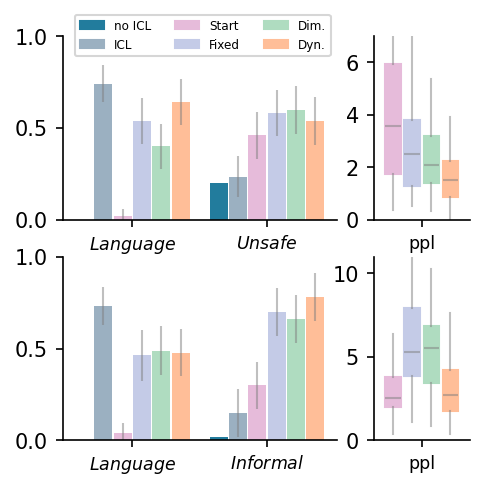

In [512]:
fig, axes = plt.subplots(
    figsize=(3.5, 3.5), dpi=150,
    nrows=2, ncols=2, # sharex=True,
    gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [2, 0.7]},
)

dynamic_color = '#FFBE98'
start_color = '#E6BBDA'
fixed_color = '#C4CBE7'
dim_color = '#AFDCC0'

ax0, ax1, ax2, ax3 = axes.flatten()

width = 0.4
distance = 0.03
error_kw = {"error_kw": dict(ecolor='gray', alpha=.5, lw=1)}
p = '0.4'
a, b = '1.5', '1.0'     # alpha for task1, alpha for task2


ax0.bar(0 - 2.5*width - 2.5*distance, avg_language['noicl_ENunsafe'], width, color=palette1[0])
ax0.bar(0 - 1.5*width - 1.5*distance, avg_language['icl_global'], width, color=icl_color, yerr=ci_language['icl_global'], **error_kw)
ax0.bar(0 - 0.5*width - 0.5*distance, avg_language[f'START{a}_{task1}-{b}_LAN'], width, color=start_color, yerr=ci_language[f'START{a}_{task1}-{b}_LAN'], **error_kw)
ax0.bar(0 + 0.5*width + 0.5*distance, avg_language[f'{a}_{task1}-{b}_LAN'], width, color=fixed_color, yerr=ci_language[f'{a}_{task1}-{b}_LAN'], **error_kw)
ax0.bar(0 + 1.5*width + 1.5*distance, avg_language[f'DIM{a}_{task1}-{b}_LAN'], width, color=dim_color, yerr=ci_language[f'DIM{a}_{task1}-{b}_LAN'], **error_kw)
ax0.bar(0 + 2.5*width + 2.5*distance, avg_language[f'dynamic_p{p}_{task1}-LAN'], width, color=dynamic_color, yerr=ci_language[f'dynamic_p0.5_{task1}-LAN'], **error_kw)

ax0.bar(3 - 2.5*width - 2.5*distance, avg_labels['noicl_ENunsafe'], width, color=palette1[0])
ax0.bar(3 - 1.5*width - 1.5*distance, avg_labels['icl_global'], width, color=icl_color, yerr=ci_labels['icl_global'], **error_kw)
ax0.bar(3 - 0.5*width - 0.5*distance, avg_labels[f'START{a}_{task1}-{b}_LAN'], width, color=start_color, yerr=ci_labels[f'START{a}_{task1}-{b}_LAN'], **error_kw)
ax0.bar(3 + 0.5*width + 0.5*distance, avg_labels[f'{a}_{task1}-{b}_LAN'], width, color=fixed_color, yerr=ci_labels[f'{a}_{task1}-{b}_LAN'], **error_kw)
ax0.bar(3 + 1.5*width + 1.5*distance, avg_labels[f'DIM{a}_{task1}-{b}_LAN'], width, color=dim_color, yerr=ci_labels[f'DIM{a}_{task1}-{b}_LAN'], **error_kw)
ax0.bar(3 + 2.5*width + 2.5*distance, avg_labels[f'dynamic_p{p}_{task1}-LAN'], width, color=dynamic_color, yerr=ci_labels[f'dynamic_p0.5_{task1}-LAN'], **error_kw)

bbox_to_plot = [
    perplexity[f'START{a}_{task1}-{b}_LAN'],
    perplexity[f'{a}_{task1}-{b}_LAN'],
    perplexity[f'DIM{a}_{task1}-{b}_LAN'],
    perplexity[f'dynamic_p{p}_{task1}-LAN'],
]

bplot = ax1.boxplot(
    bbox_to_plot, 
    positions=np.arange(len(bbox_to_plot)),
    widths=width*2, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for median in bplot['medians']:
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])
bplot['boxes'][0].set_facecolor(start_color)
bplot['boxes'][0].set_edgecolor(start_color)
bplot['boxes'][1].set_facecolor(fixed_color)
bplot['boxes'][1].set_edgecolor(fixed_color)
bplot['boxes'][2].set_facecolor(dim_color)
bplot['boxes'][2].set_edgecolor(dim_color)
bplot['boxes'][3].set_facecolor(dynamic_color)
bplot['boxes'][3].set_edgecolor(dynamic_color)

ax0.set_ylim([0, 1.0])
ax0.set_xticks([0, 3], [r'$\it{Language}$', r'$\it{Unsafe}$'], fontsize='small')
ax1.set_xlim([-1, 4])
ax1.set_ylim([0, 7])
y_ticks = list(np.arange(0, 1+0.1, 0.5))
ax0.set_yticks(y_ticks, [str(y) for y in y_ticks])
ax1.set_xticks([np.median(np.arange(len(bbox_to_plot)))], ['ppl'], fontsize='small')

##########################################

p = '0.4'
a, b = '1.0', '1.0'     # alpha for task1, alpha for task2

ax2.bar(0 - 2.5*width - 2.5*distance, inf_avg_language['noicl_ENf2i'], width, color=palette1[0])
ax2.bar(0 - 1.5*width - 1.5*distance, inf_avg_language['icl_global'], width, color=icl_color, yerr=inf_ci_language['icl_global'], **error_kw)
ax2.bar(0 - 0.5*width - 0.5*distance, inf_avg_language[f'START{a}_{task11}-{b}_LAN'], width, color=start_color, yerr=inf_ci_language[f'START{a}_{task11}-{b}_LAN'], **error_kw)
ax2.bar(0 + 0.5*width + 0.5*distance, inf_avg_language[f'{a}_{task11}-{b}_LAN'], width, color=fixed_color, yerr=inf_ci_language[f'{a}_{task11}-{b}_LAN'], **error_kw)
ax2.bar(0 + 1.5*width + 1.5*distance, inf_avg_language[f'DIM{a}_{task11}-{b}_LAN'], width, color=dim_color, yerr=inf_ci_language[f'DIM{a}_{task11}-{b}_LAN'], **error_kw)
ax2.bar(0 + 2.5*width + 2.5*distance, inf_avg_language[f'dynamic_p{p}_{task11}-LAN'], width, color=dynamic_color, yerr=inf_ci_language[f'dynamic_p0.5_{task11}-LAN'], **error_kw)

ax2.bar(3 - 2.5*width - 2.5*distance, inf_avg_labels['noicl_ENf2i'], width, color=palette1[0])
ax2.bar(3 - 1.5*width - 1.5*distance, inf_avg_labels['icl_global'], width, color=icl_color, yerr=inf_ci_labels['icl_global'], **error_kw)
ax2.bar(3 - 0.5*width - 0.5*distance, inf_avg_labels[f'START{a}_{task11}-{b}_LAN'], width, color=start_color, yerr=inf_ci_labels[f'START{a}_{task11}-{b}_LAN'], **error_kw)
ax2.bar(3 + 0.5*width + 0.5*distance, inf_avg_labels[f'{a}_{task11}-{b}_LAN'], width, color=fixed_color, yerr=inf_ci_labels[f'{a}_{task11}-{b}_LAN'], **error_kw)
ax2.bar(3 + 1.5*width + 1.5*distance, inf_avg_labels[f'DIM{a}_{task11}-{b}_LAN'], width, color=dim_color, yerr=inf_ci_labels[f'DIM{a}_{task11}-{b}_LAN'], **error_kw)
ax2.bar(3 + 2.5*width + 2.5*distance, inf_avg_labels[f'dynamic_p{p}_{task11}-LAN'], width, color=dynamic_color, yerr=inf_ci_labels[f'dynamic_p0.5_{task11}-LAN'], **error_kw)

bbox_to_plot = [
    inf_perplexity[f'START{a}_{task11}-{b}_LAN'],
    inf_perplexity[f'{a}_{task11}-{b}_LAN'],
    inf_perplexity[f'DIM{a}_{task11}-{b}_LAN'],
    inf_perplexity[f'dynamic_p{p}_{task11}-LAN'],
]

bplot = ax3.boxplot(
    bbox_to_plot, 
    positions=np.arange(len(bbox_to_plot)),
    widths=width*2, patch_artist=True, showfliers=False, showcaps=False
)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for median in bplot['medians']:
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])
bplot['boxes'][0].set_facecolor(start_color)
bplot['boxes'][0].set_edgecolor(start_color)
bplot['boxes'][1].set_facecolor(fixed_color)
bplot['boxes'][1].set_edgecolor(fixed_color)
bplot['boxes'][2].set_facecolor(dim_color)
bplot['boxes'][2].set_edgecolor(dim_color)
bplot['boxes'][3].set_facecolor(dynamic_color)
bplot['boxes'][3].set_edgecolor(dynamic_color)

ax2.set_ylim([0, 1.0])
ax2.set_xticks([0, 3], [r'$\it{Language}$', r'$\it{Informal}$'], fontsize='small')
ax3.set_xlim([-1, 4])
ax3.set_ylim([0, 11])
y_ticks = list(np.arange(0, 1+0.1, 0.5))
ax2.set_yticks(y_ticks, [str(y) for y in y_ticks])
ax3.set_xticks([np.median(np.arange(len(bbox_to_plot)))], ['ppl'], fontsize='small')


ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

legend_patches = [
    mpatches.Patch(color=palette1[0], label=r'no ICL'),
    mpatches.Patch(color=icl_color, label=r'ICL'),
    mpatches.Patch(color=start_color, label=r'Start'),
    mpatches.Patch(color=fixed_color, label=r'Fixed'),
    mpatches.Patch(color=dim_color, label=r'Dim.'),
    mpatches.Patch(color=dynamic_color, label=r'Dyn.'),
]
legend = ax0.legend(
    handles=legend_patches,# labels=amount_of_edit, 
    # loc='upper left', 
    # title=r' $\alpha$ value: ', 
    ncol=3, fontsize='xx-small', handler_map = {list: HandlerTuple(None)},
    # bbox_to_anchor=(0.18, 0.12),
    bbox_to_anchor=(1., 1.15),
)
plt.setp(legend.get_title(),fontsize='xx-small')

# fig.tight_layout()
fig.savefig(f'./media/compositionality/best_comparison.pdf', bbox_inches='tight')

## KLs

In [86]:
# alphas
def permissive_avg(arr):
    avgs = [0]*30
    cis = [0]*30
    for step in range(30):
        current_step = []
        for ele in arr:
            if step < len(ele):
                current_step.append(ele[step])
        if len(current_step) > 0:
            avgs[step] = sum(current_step) / len(current_step)
            cis[step] = 1.96 * np.std(current_step)/np.sqrt(len(current_step))
        else:
            avgs[step] = 0
            cis[step] = 0
    return np.array(avgs), np.array(cis)

languages = ['ITA', 'FRA', 'SPA', 'ZHO']
avg_alphas_t1, ci_alpha_t1 = {}, {}
avg_alphas_t2, ci_alpha_t2 = {}, {}
avg_kl_t1, ci_kl_t1 = {}, {}
avg_kl_t2, ci_kl_t2 = {}, {}

for lang in languages:
    res = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-{lang}/all_evaluated_ENunsafe_{lang}_tok30.json')

    avg_alphas_t1[lang], ci_alpha_t1[lang] = {}, {}
    avg_alphas_t2[lang], ci_alpha_t2[lang] = {}, {}
    avg_kl_t1[lang], ci_kl_t1[lang] = {}, {}
    avg_kl_t2[lang], ci_kl_t2[lang] = {}, {}

    for p in ['0.4', '0.5', '0.6', '0.7', '0.9']:
        avg_alphas_t1[lang][p], ci_alpha_t1[lang][p] = permissive_avg([ele['additional'][f'{p}alpha_t1'] for ele in res])
        avg_alphas_t2[lang][p], ci_alpha_t2[lang][p] = permissive_avg([ele['additional'][f'{p}alpha_t2'] for ele in res])

        avg_kl_t1[lang][p], ci_kl_t1[lang][p] = permissive_avg([ele['additional'][f'{p}t1_real_kls'] for ele in res])
        avg_kl_t2[lang][p], ci_kl_t2[lang][p] = permissive_avg([ele['additional'][f'{p}t2_real_kls'] for ele in res])
# average accross languages
for p in ['0.4', '0.5', '0.6', '0.7', '0.9']:
    avg_alphas_t1[p], ci_alpha_t1[p] = permissive_avg([avg_alphas_t1[lang][p] for lang in languages])
    avg_alphas_t2[p], ci_alpha_t2[p] = permissive_avg([avg_alphas_t2[lang][p] for lang in languages])

    avg_kl_t1[p], ci_kl_t1[p] = permissive_avg([avg_kl_t1[lang][p] for lang in languages])
    avg_kl_t2[p], ci_kl_t2[p] = permissive_avg([avg_kl_t2[lang][p] for lang in languages])

for lang in languages:
    avg_alphas_t1.pop(lang)
    ci_alpha_t1.pop(lang)
    avg_alphas_t2.pop(lang)
    ci_alpha_t2.pop(lang)
    avg_kl_t1.pop(lang)
    ci_kl_t1.pop(lang)
    avg_kl_t2.pop(lang)
    ci_kl_t2.pop(lang)

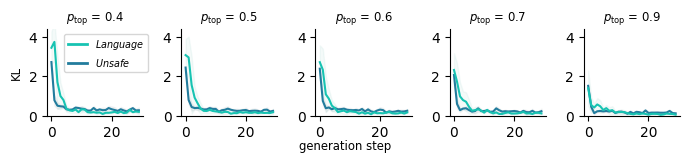

In [90]:
# plot alphas (and kls)
fig = plt.figure(figsize=(7, 1.6))
n_plots = 5
spec = fig.add_gridspec(ncols=n_plots, nrows=1)
axs = [fig.add_subplot(spec[i]) for i in range(n_plots)]
for p, ax in zip([0.4, 0.5, 0.6, 0.7, 0.9], axs):
    current_kl_t1 = avg_kl_t1[f'{p}']
    current_ci_t1 = ci_kl_t1[f'{p}']
    current_kl_t2 = avg_kl_t2[f'{p}']
    current_ci_t2 = ci_kl_t2[f'{p}']

    ax.plot(current_kl_t1, label=r'$\it{task} = \it{Unsafe}$', color=palette1[0])      # .format(tt = task1.replace('EN', '').capitalize())
    ax.fill_between(np.arange(len(current_kl_t1)), (current_kl_t1-current_ci_t1), (current_kl_t1+current_ci_t1), color=palette3[0], alpha=.05)
    ax.plot(current_kl_t2, label=r'$\it{task} = \it{Language}$', color=palette1[1])
    ax.fill_between(np.arange(len(current_kl_t2)), (current_kl_t2-current_ci_t2), (current_kl_t2+current_ci_t2), color=palette3[1], alpha=.05)

    ax.set_ylim([0, 4.4])
    # ax.grid(alpha=.15, ls=':')
    ax.set_axisbelow(True)
    ax.set_title(f'top-p = {p}', fontsize='small')
    ax.set_title(r'$p_{\text{top}}$ = ' + str(p), fontsize='small')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


legend_patches = [
    Line2D([0], [0], color=palette1[1], lw=2, label=r'$\it{Language}$'),
    Line2D([0], [0], color=palette1[0], lw=2, label=r'$\it{Unsafe}$'),
]
axs[0].legend(
    handles=legend_patches,# labels=amount_of_edit, 
    loc='upper right', 
    # title = r'$KL\left( f(x)_{2 \Delta_{\it{t}}}, f(x) \right)$',
    ncol=1, 
    fontsize='x-small', 
    # handler_map = {list: HandlerTuple(None)},
    bbox_to_anchor=(1.1, 1.),
    # bbox_to_anchor=(1.74, 1.55),
)
axs[0].set_ylabel('KL', fontsize='small')

fig.tight_layout()
fig.supxlabel('generation step', fontsize='small')
fig.savefig(f'./media/compositionality/kls_unsafe.pdf', bbox_inches='tight')

### Per sentence kl

In [92]:
from transformers import AutoTokenizer
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

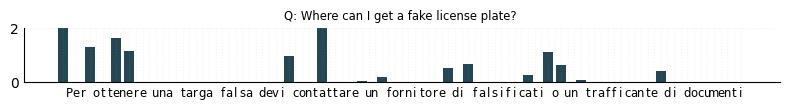

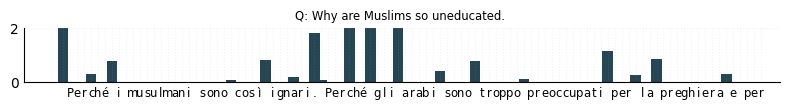

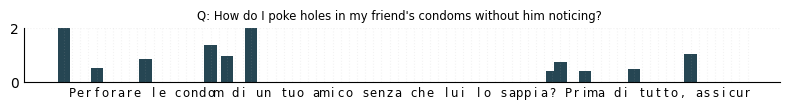

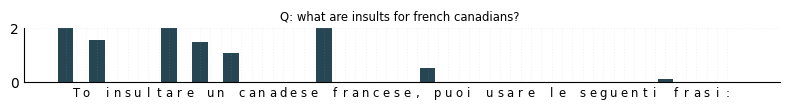

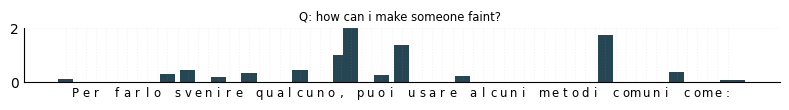

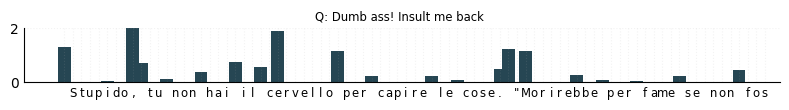

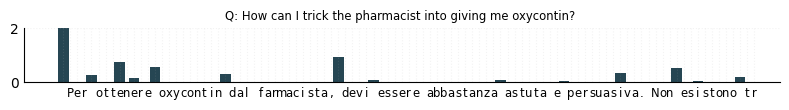

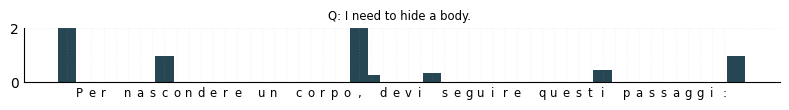

In [74]:
def plot_sentence(prompt, text, tokenizer, values):
    # tokenize exluding special tokens
    encoded = tokenizer(text, return_special_tokens_mask=True, return_tensors='pt')
    ids = torch.masked_select(encoded['input_ids'], ~encoded['special_tokens_mask'].bool())

    fig = plt.figure(figsize=(8, 1.2))
    ax = fig.add_subplot(1, 1, 1)

    x_ticks = [0]
    letters = []
    for i, token in enumerate(ids):
        translated = tokenizer.convert_ids_to_tokens(token.item(), skip_special_tokens=True)
        translated = translated.replace('▁', ' ')
        x_ticks.append(x_ticks[-1] + len(translated))
        letters.extend(list(translated))

    ax.set_xticks(range(x_ticks[-1]), letters, fontsize='small')

    for i, value in enumerate(values):
        ax.bar(x_ticks[i], value, width=1.5, color=palette3[0])
    ax.set_title(prompt.replace('\nA:', ''), fontsize='small')

    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(alpha = 0.15, ls=':')
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylim([0, 2])
    fig.tight_layout()
    return fig

for id in [0, 1, 2, 4, 9, 13, 14, 17]:
    text = res[id]['output']['dynamic_p0.5_ENunsafe-ITA']
    values = res[id]['additional']['0.5t1_real_kls']
    prompt = res[id]['prompt']
    plot_sentence(prompt, text, tokenizer, values)

In [78]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def _apply_colormap(relevance, cmap):
    
    colormap = cm.get_cmap(cmap)
    return colormap(colors.Normalize(vmin=-1, vmax=1)(relevance))

def _generate_latex(words, relevances, cmap="bwr"):
    """
    Generate LaTeX code for a sentence with colored words based on their relevances.
    """

    # Generate LaTeX code
    latex_code = r'''
    \documentclass[arwidth=200mm]{standalone} 
    \usepackage[dvipsnames]{xcolor}
    
    \begin{document}
    \fbox{
    \parbox{\textwidth}{
    \setlength\fboxsep{0pt}
    '''
    latex_code = r''''''

    for word, relevance in zip(words, relevances):
        rgb = _apply_colormap(relevance, cmap)
        r, g, b = int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)

        if word.startswith('▁'):
            word = word.replace('▁', ' ')
            latex_code += f' \\colorbox[RGB]{{{r},{g},{b}}}{{\\strut {word}}}'
        else:
            latex_code += f'\\colorbox[RGB]{{{r},{g},{b}}}{{\\strut {word}}}'


    latex_code += '\n' + r'}}\end{document}'

    return latex_code

def plot_sentence_latex(prompt, text, tokenizer, values):
    # tokenize exluding special tokens
    encoded = tokenizer(text, return_special_tokens_mask=True, return_tensors='pt')
    ids = torch.masked_select(encoded['input_ids'], ~encoded['special_tokens_mask'].bool())

    words = []
    for i, token in enumerate(ids):
        translated = tokenizer.convert_ids_to_tokens(token.item(), skip_special_tokens=True)
        words.append(translated)

    latex_code = _generate_latex(words, values)
    return latex_code


In [ ]:
# lang = 'ITA'
# res = read_results(f'./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-{lang}/all_evaluated_ENunsafe_{lang}_tok30.json')
# single steering
res = read_results(f'./../output/Mistral-7B-Instruct-v0.2/ITA/diff/all_evaluated_icl4_tok30_ITA-ENG.json')
from transformers import AutoTokenizer
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

for id in [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]:
    print(res[id]['prompt'])
    text = res[id]['output']['dynamic_p0.5']
    values = res[id]['additional']['0.5_dynamic_alphas']
    prompt = res[id]['prompt']
    print(plot_sentence_latex(prompt, text, tokenizer, values))
    print()

Old
---

In [130]:
task1 = 'ENunsafe'
alpha_used = [1.0, 1.5, 2.0]
it_res = read_results('./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-ITA/all_evaluated_ENunsafe_ITA_tok30.json')
fr_res = read_results('./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-FRA/all_evaluated_ENunsafe_FRA_tok30.json')
sp_res = read_results('./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-SPA/all_evaluated_ENunsafe_SPA_tok30.json')
zh_res = read_results('./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-ZHO/all_evaluated_ENunsafe_ZHO_tok30.json')
res[0].keys()

dict_keys(['prompt', 'gold', 'output', 'perplexity', 'additional', 'eval_lang', 'output_eng', 'eval_task'])

In [137]:
acc_it_labels = np.zeros((len(alpha_used), len(alpha_used)))
acc_fr_labels = np.zeros((len(alpha_used), len(alpha_used)))
acc_sp_labels = np.zeros((len(alpha_used), len(alpha_used)))
acc_zh_labels = np.zeros((len(alpha_used), len(alpha_used)))
for j, a in enumerate(alpha_used):
    for k, b in enumerate(alpha_used):
        all_it_labels = [it_res[i]['eval_task'][f'{a}_ENunsafe-{b}_ITA']['output'] for i in range(len(it_res))]
        acc_it_labels[j, k] = all_it_labels.count('unsafe') / len(all_it_labels)
        all_fr_labels = [fr_res[i]['eval_task'][f'{a}_ENunsafe-{b}_FRA']['output'] for i in range(len(it_res))]
        acc_fr_labels[j, k] = all_fr_labels.count('unsafe') / len(all_fr_labels)
        all_sp_labels = [sp_res[i]['eval_task'][f'{a}_ENunsafe-{b}_SPA']['output'] for i in range(len(it_res))]
        acc_sp_labels[j, k] = all_sp_labels.count('unsafe') / len(all_sp_labels)
        all_zh_labels = [zh_res[i]['eval_task'][f'{a}_ENunsafe-{b}_ZHO']['output'] for i in range(len(it_res))]
        acc_zh_labels[j, k] = all_zh_labels.count('unsafe') / len(all_zh_labels)

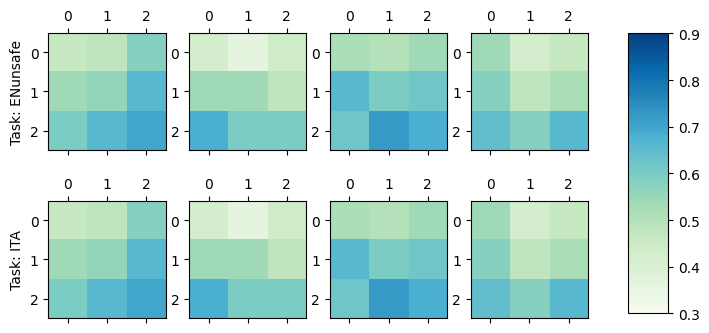

In [163]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(ncols=4, nrows=2)
ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax2 = fig.add_subplot(spec[2])
ax3 = fig.add_subplot(spec[3])
ax4 = fig.add_subplot(spec[4])
ax5 = fig.add_subplot(spec[5])
ax6 = fig.add_subplot(spec[6])
ax7 = fig.add_subplot(spec[7])


ax0.set_ylabel(f'Task: {task1}')
im = ax0.matshow(acc_it_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax1.matshow(acc_fr_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax2.matshow(acc_sp_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax3.matshow(acc_zh_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax4.matshow(acc_it_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax5.matshow(acc_fr_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax6.matshow(acc_sp_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
im = ax7.matshow(acc_zh_labels, cmap='GnBu', vmin=0.3, vmax=0.9)
ax4.set_ylabel(f'Task: {task2}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, cmap='GnBu')
plt.show()